<a href="https://colab.research.google.com/github/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/blob/main/VIS25-Z2-TIM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadaća 2 - Statistička analiza svjetskih univerziteta

Tim 1: **Adnan Muradbegović, Aid Mustafić, Tarik Redžić, Zlatan Ljutika**

---

Teško je pronaći opću mjeru kvalitete za visokoobrazovne institucije, s tim da se većina univerziteta širom svijeta bavi mnogim različitim oblastima, kao što su nastava, istraživanje i razmjena znanja. 
Ipak, odlučiti se za način predviđanja ukupne kvalitete institucije bilo bi poželjno za one koji žele donijeti informisanu odluku o tome da li da se angažuju s određenim univerzitetom, bilo kao student, istraživač ili partner iz industrije.

U ovom projektu, izvršavamo statističku analizu _[Times Higher Education](https://www.timeshighereducation.com)_ rang liste svjetskih univerziteta za 2024. godinu.

Izvor podataka: <br>
**[Dosad, D. (2024), Times World University Rankings 2024](https://www.kaggle.com/datasets/ddosad/timesworlduniversityrankings2024)**



In [3]:
# Učitavanje nužnih biblioteka i inicijalizacija seta podataka za rad
# !curl -LJO https://raw.githubusercontent.com/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/main/TIMES_WorldUniversityRankings_2024.csv
# Ne do vam Bog ovo uncomment-irat i runat dok nismo završili. (Privatni je repo pa samo OBRIŠE ČITAV CSV I STAVI "404 NOT FOUND")

import pandas as pd                   ## Za manipulisanje golih podataka, (CSV, DataFrame,...)
import matplotlib.pyplot as plt       ## Za vizualizaciju podataka
import seaborn as sns                 ## Za vizualizaciju podat
import numpy as np                    ## Za izvršavanje matematičkih operacija nad podacima
from numpy import cov
from IPython.display import HTML    ## Za kreiranje tabela i HTML manipulaciju
from IPython.display import Markdown
import statistics

df = pd.read_csv("TIMES_WorldUniversityRankings_2024.csv")

# Nužni koraci, postoje greške u notaciji polja i tipovima podataka u datasetu.
# Procent intl. studenta je sada 0.X, umjesto X%
# Proporcija ženskih-muških studenata je sada 0.X, umjesto 'X : Y'
# N/A podaci su zapisani kao proracunati mean
df['stats_number_students'] = df['stats_number_students'].str.replace(',', '').astype(float) 

mask = df['stats_pc_intl_students'].str.match(r'^\d+(\.\d+)?%$')
df.loc[~mask, 'stats_pc_intl_students'] = '0%'
df['stats_pc_intl_students'] = df['stats_pc_intl_students'].str.rstrip('%')
df['stats_pc_intl_students'] = (df['stats_pc_intl_students'].astype(float) / 100)

df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(str).str.replace(' ','',regex=False)
mask = df['stats_female_male_ratio'].str.match(r'^\d+\s*:\s*\d+$')
female_ratio = df.loc[mask, 'stats_female_male_ratio'].str.replace(' ', '', regex=False).str.split(':')
female_ratio = female_ratio.apply(lambda x: int(x[0]) / (int(x[0]) + int(x[1])))
mean_f_ratio = female_ratio.mean()

df['stats_female_male_ratio'] = None
df.loc[mask, 'stats_female_male_ratio'] = female_ratio
df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(float).fillna(mean_f_ratio)
df['female_ratio_imputed'] = ~mask # Ubačen flag da li je ubačena vrijednost ili ne. (Bool: da li je ubačena?)

### 1. Deskriptivna statistika i vizualizacija distribucija podataka

Član tima: **Tarik Redžić**

---

 _THE rang lista svjetskih univerziteta 2024. godine_ se sastoji od ukupno **1904 univerziteta** iz 108 zemalja i regija.  
 U ovom poglavlju nastojimo prvenstveno opisati i upoznati se metodologiju rangiranja, način obrade podataka u ovom setu te korištenim parametrima.
 _U nastavku, važna je napomena da opis seta podataka i rang liste analogno važe jedno za drugo._

_Jedna zanimljivost, koju ćemo posebno razmatrati kroz ovaj projekt je da je ovo prvo pojavljivanje Univerziteta u Sarajevu, te tako i **prvo pojavljavanje jedne visokoobrazovne institucije iz Bosne i Hercegvine na ovoj rang listi**, što je čak i istaknuto na web-stranici rang liste._ 
> ,,Four countries enter the ranking for the first time – all of them in Europe. The addition of Kosovo, Bosnia and Herzegovina, North Macedonia and Armenia..."



##### **Metodologija i parametri**  
> ,,The table is based on our new WUR 3.0 methodology, which includes 18 carefully calibrated performance indicators that measure an institution’s performance across five areas: teaching, research environment, research quality, industry, and international outlook."  
  \- Times Higher Education
  


  _Set podataka se sastoji od:_  
* **Broj redova (univerziteta): _2673_**
    
    Pored 1904 rangiranih univerziteta, ***postoje 769 sa 'Reporter' statusom,*** tj. univerziteti koji su proslijedili podatke ali nisu zadovoljavali kriterij za rank, ali su prihvatili da budu prikazani kao "reporteri" u konačnoj tabeli.  
    *(Primjer, na jednoj rang listi, sa Reporter statusom se nalazi "University of Mostar", da li to bio UNMO/Džemal Bijedić ili SUM/Sveučilište u Mostaru, nije poznato, te se ne broji kao visokoobrazovna ustanova uvrštena u ovu rang listu)*

* **Broj kolona: _29, od kojih je 17 parametara pokazatelja učinka iz metodologije._**

   ***Parametri su grupisani na sljedeći način:***  
     * Teaching _(bos. 'Nastava', u datasetu: **'scores_teaching'**)_
        * Teaching Reputation _(bos. **'Reputacija nastave'**)_
        * Student Staff Ratio _(bos. **Proporcija Student-Osoblje,** u datasetu: **'stats_student_staff_ratio'**)_
        * Doctorate Bachelor Ratio _(bos. **Proporcija Doktorat-Bakalaureat,**)_
        * Doctorate Staff Ratio _(bos. **Proporcija Doktorat-Osoblje,**)_
        * Institutional Income _(bos. **Prihod institucije,**)_
        * Research Environment _(bos. **Istraživačko okruženje**)_
        * Research Reputation _(bos. '**Istraživačka reputacija**)_
        * Research Income _(bos. **Prihodi od istraživanja,**)_
        * Research Productivity _(bos. **Produktivnost u istraživanju,**)_
        * Research Quality _(bos. **Kvaliteta istraživanja,**)_
        * Citation Impact _(bos. **Uticaj pri citiranju,** u datasetu: **'scores_citation'**)_
        * Research Strength _(bos. **Istraživačka snaga,**)_
        * Research Excellence _(bos. **Kvaliteta istraživanja,**)_
        * Research Influence _(bos. **Istraživački uticaj,**)_
    * International outlook _(bos. **'Međunarodni povezanost'**, u datasetu: **'scores_international_outlook'**)_
        * International Students _(bos. **Međunarodni studenti,** u datasetu: **'stats_pc_intl_students'**)_
        * International Staff _(bos. **Međunarodno osoblje**)_
        * International Co-authorship _(bos. **Međunarodno koautorstvo**)_
    * Industry
        * Industry Income _(bos. **Prihodi od industrije,** u datasetu: **'scores_industry_income'**)_
        * Patents _(bos. **Patenti**)_


_**Napomena:** Radi statističke analize, ovo nije potpuni spisak parametara, već onih obrađenih i prevedenih u ovaj set podataka kao parametri. Više informacija o WUR metodologiji možete pronaći [ovdje.](https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf)_


In [4]:
# TODO: @TarikRedzic, fino ispuni ovo gore. Ostavio sam ti template. Što nema u datasetu, obriši, zato ti je ova posljednja rečenica.

In [5]:
###@title **Tabela 1: Primjer zapisa u setu podataka"** { display-mode: "form" }
display(df[df['scores_overall_rank'] == 18290])
display(Markdown('Tabela 1: Primjer zapisa u setu podataka'))

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited,disabled,website_url,female_ratio_imputed
1828,1501+,University of Sarajevo,9.7–22.7,18290,16.4,1673,10.8,1552,18.6,1707,...,15.6,0.0,0.64,University of Sarajevo,"Languages, Literature & Linguistics,Agricultur...",False,False,False,NaN,False


Tabela 1: Primjer zapisa u setu podataka

In [6]:
df_display = df[['scores_overall_rank','scores_teaching','scores_research','scores_citations','scores_international_outlook','stats_number_students','scores_industry_income','stats_pc_intl_students','stats_female_male_ratio']]
pd.set_option('display.float_format', '{:.2f}'.format)
print("Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre") # TODO: @TarikRedzic, ovo ljepše ispiši
df_display.describe()


Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre


,scores_overall_rank,scores_teaching,scores_research,scores_citations,scores_international_outlook,stats_number_students,scores_industry_income,stats_pc_intl_students,stats_female_male_ratio
count,2673.00,1904.00,1904.00,1904.00,1904.00,2673.00,1904.00,2673.00,2673.00
mean,294587.23,29.06,23.42,52.19,49.91,18357.77,47.06,0.10,0.51
std,448657.02,13.97,16.70,25.07,21.83,23325.31,26.15,0.13,0.14
min,10.00,9.40,4.60,3.40,16.10,25.00,15.60,0.00,0.00
25%,6690.00,19.40,11.80,30.40,31.98,6175.00,22.27,0.01,0.44
50%,13370.00,25.80,17.25,52.40,45.30,12771.00,41.05,0.05,0.53
75%,1000101.00,34.50,29.90,73.22,65.40,23951.00,68.20,0.13,0.59
max,1000769.00,99.00,100.00,99.70,98.80,482541.00,100.00,1.00,1.00


In [7]:
# TODO: @TarikRedzic, izvuci neki zakljucak ako ima ili navedi koje sam promjene uradio na vrhu notebook-a (tipa ono sa meanom)

Prolaskom kroz bazu podataka vidljivo je da mnogi univerziteti ili nemaju nikakvog uspjeha u pogledu prethodno navedenih kriterija ili jednostavno nema pronađenih dovoljno preciznih podataka o njima, pa je odabir bio da se na ta mjesta stavi vrijednost 0, tako da ćemo sada vizualizirati stanje bez takvih univerziteta.

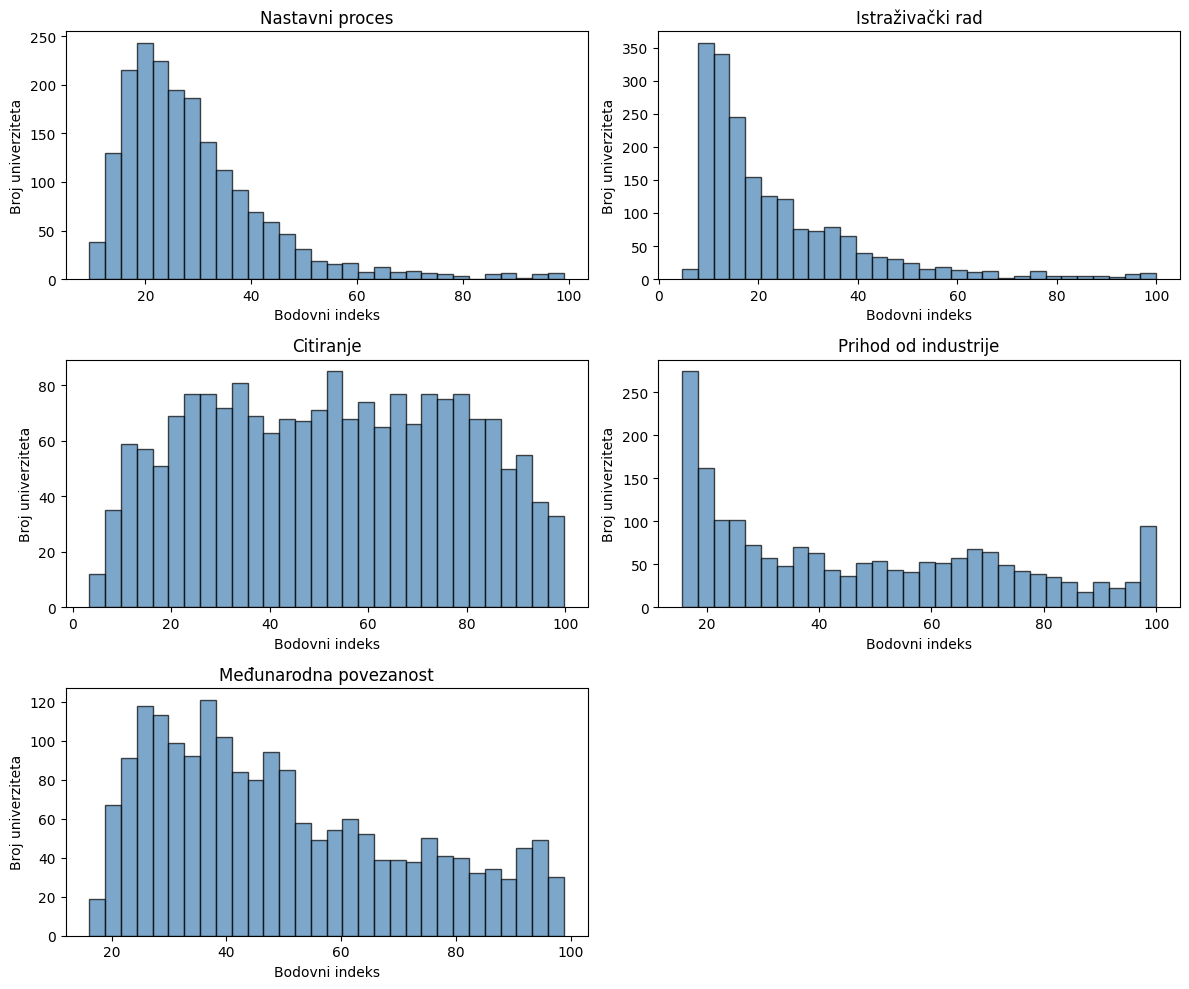

In [8]:
major_scores = [
    'scores_teaching',
    'scores_research',
    'scores_citations',
    'scores_industry_income',
    'scores_international_outlook'
]

for col in major_scores:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[f'{col}_imputed'] = df[col].isna()
    df[col] = df[col].fillna(0)

filtered_data = {}
for col in major_scores:
    filtered_data[col] = df[df[col] > 0][col]

imputed_counts = {}
actual_counts = {}
valid_counts = {}  

for col in major_scores:
    imputed_col = f'{col}_imputed'
    imputed_counts[col] = df[imputed_col].sum()
    actual_counts[col] = len(df) - df[imputed_col].sum()
    valid_counts[col] = len(filtered_data[col])  


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(major_scores):
    axes[i].hist(filtered_data[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    
    #title = f"{col.replace('scores_', '').replace('_', ' ').title()}\n"
    #title += f"(Valid: {valid_counts[col]}, Zeros: {actual_counts[col] - valid_counts[col]}, Missing: {imputed_counts[col]})"
    
    match i:
        case 0:
            title = f"Nastavni proces"
        case 1:
            title = f"Istraživački rad"
        case 2:
            title = f"Citiranje"
        case 3:
            title = f"Prihod od industrije"
        case 4:
            title = f"Međunarodna povezanost"


    axes[i].set_title(title)
    axes[i].set_xlabel('Bodovni indeks')
    axes[i].set_ylabel('Broj univerziteta')

if len(major_scores) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Sada imamo puno bolji uvid u realno stanje te možemo vidjeti distribucije koje jako podsjećaju na neke poznate oblike. Recimo distribucija za istraživački rad jako podsjeća na gamma distribuciju, dok nastavni proces i u neku ruku i međunarodna povezanost podsjećaju na lognormalnu distribuciju. Dotaknuti ćemo se dodatne analize nešto kasnije.

Sada pogledajmo kako su kontinenti zastupljeni

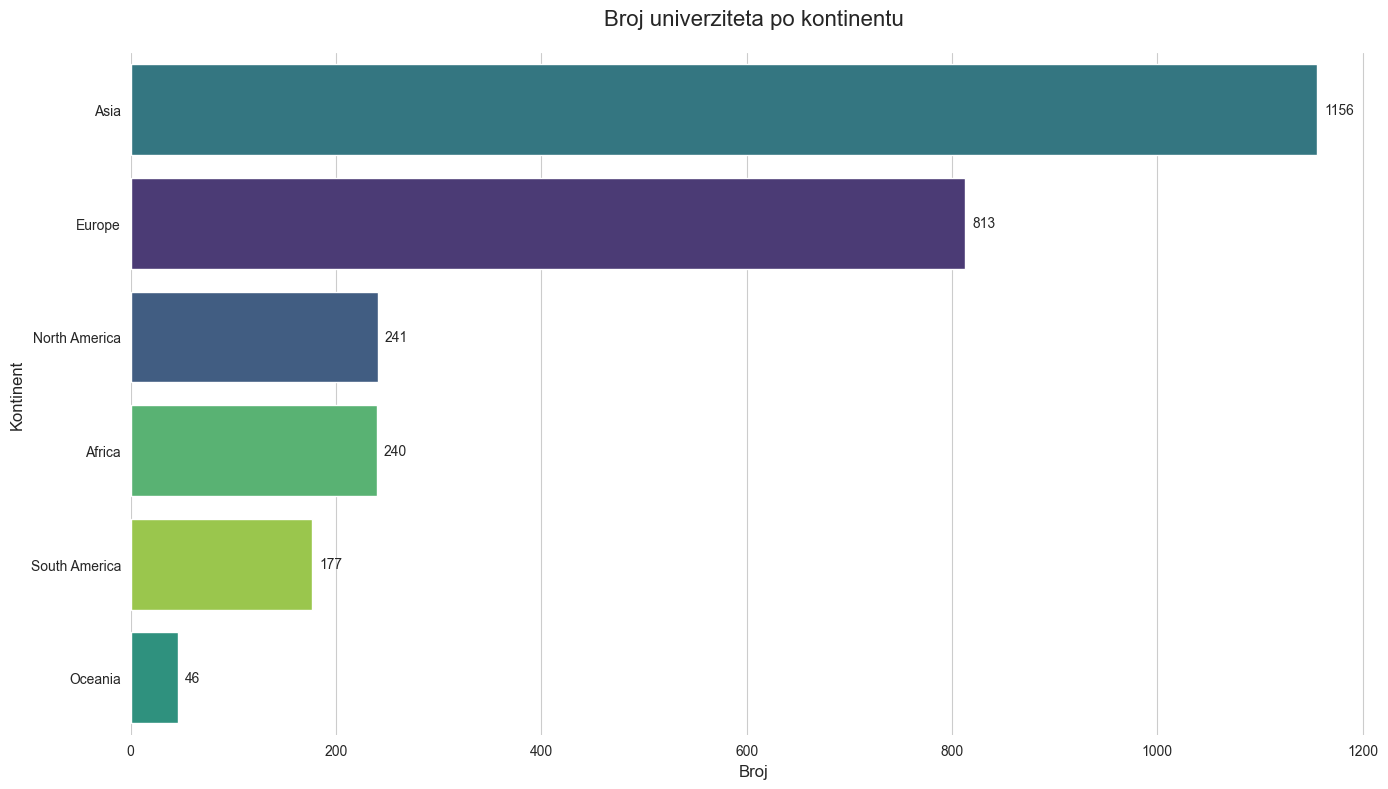

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc


def get_continent(country_name):
    country_mapping = {
        'USA': 'United States',
        'US': 'United States',
        'UK': 'United Kingdom',
        'UAE': 'United Arab Emirates',
        'Hong Kong': 'China',
        'Macau': 'China',
        'Republic of Ireland': 'Ireland',
        'Russian Federation': 'Russia',
        'Taiwan': 'China',
        'Palestine, State of': 'Palestine',
        'Kosovo': 'Serbia'
    }
    
    standardized_name = country_mapping.get(country_name, country_name)
    
    try:
        country_code = pc.country_name_to_country_alpha2(standardized_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        try:
            for suffix in [' of', ' the', ' and']:
                if suffix in standardized_name:
                    standardized_name = standardized_name.split(suffix)[0]
                    break
            country_code = pc.country_name_to_country_alpha2(standardized_name)
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            return pc.convert_continent_code_to_continent_name(continent_code)
        except:
            print(f"Could not map country: {country_name}")
            return 'Unknown'

continent_data = df['location'].apply(get_continent)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.countplot(y=continent_data, 
                  order=continent_data.value_counts().index,
                  hue=continent_data,  
                  palette="viridis",
                  legend=False)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width()):}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', 
               xytext=(5, 0), 
               textcoords='offset points',
               fontsize=10)

plt.title("Broj univerziteta po kontinentu", fontsize=16, pad=20)
plt.xlabel("Broj", fontsize=12)
plt.ylabel("Kontinent", fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()

unmapped = df[continent_data == 'Unknown']['location'].unique()
if len(unmapped) > 0:
    print("\nUnmapped countries found:")
    for country in unmapped:
        print(f"- {country}")

plt.show()

Prije nego što prođemo kroz ovaj histogram, čisto da napomenem da je bilo sitnih problema sa kompilacijom ovog koda, jer bibliotečka funkcija korištena za mapiranje država u kontinente ne priznaje Kosovo kao nezavisnu državu, što je slučaj sa bazom podataka koju koristimo, ali to u ovom slučaju ne pravi problem pri brojanju. 

Napomenimo još da su o ovom histogramu uključeni i univerziteti koji nisu službeno na listi, ali se nalaze u bazi podataka.
Vidljivo je da Azija ima daleko najviše visokorangiranih univerziteta, popraćeni Evropom koja također ima respektabilan broj. Nakon toga slijede Sjeverna Amerika i Afrika sa minimalnom razlikom u broju, što je dobar pokazatelj kolika je razlika u napretku obrazovnog sistema na ovim kontinentima poredeći broj država (ništa neočekivano ako se uzmu u obzir historija i sadašnjost). Južna Amerika se pojavljuje sa 177 univerziteta. Na samom kraju imamo Okeaniju sa 46 univerziteta, ali znajući da je taj dio svijeta vrlo malo naseljen, nije se mogla ni očekivati drugačija pozicioniranost ovog "kontinenta" na listi.

Pogledajmo nabrzaka stanje na našem poluotoku i broj univerziteta na listi po svakoj državi.

In [13]:
# Definisanje balkanskih država (Kosovo kao dio Srbije, uključena i Turska)
balkanske_drzave = {
    'Albanija': 'ALB',
    'Bosna i Hercegovina': 'BIH',
    'Bugarska': 'BGR',
    'Hrvatska': 'HRV',
    'Grčka': 'GRC',
    'Crna Gora': 'MNE',
    'Sjeverna Makedonija': 'MKD',
    'Rumunija': 'ROU',
    'Srbija': 'SRB',   # Uključuje Kosovo
    'Slovenija': 'SVN',
    'Turska': 'TUR'    # Dodano
}

# Priprema podataka
balkanski_podaci = df[df['location'].isin([
    'Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
    'Greece', 'Montenegro', 'North Macedonia',
    'Romania', 'Serbia', 'Slovenia', 'Kosovo', 'Turkey'
])].copy()

# Grupisanje - Kosovo se dodaje Srbiji
balkanski_podaci['location'] = balkanski_podaci['location'].replace({
    'Kosovo': 'Serbia',
})

# Brojanje univerziteta po državama
broj_univerziteta = balkanski_podaci['location'].value_counts().reset_index()
broj_univerziteta.columns = ['Država', 'Broj univerziteta']

# Prevodimo nazive država na bosanski
prevod = {
    'Serbia': 'Srbija',
    'Montenegro': 'Crna Gora',
    'North Macedonia': 'Sjeverna Makedonija',
    'Albania': 'Albanija',
    'Bosnia and Herzegovina': 'Bosna i Hercegovina',
    'Bulgaria': 'Bugarska',
    'Croatia': 'Hrvatska',
    'Greece': 'Grčka',
    'Romania': 'Rumunija',
    'Slovenia': 'Slovenija',
    'Turkey': 'Turska'  # Dodano
}

broj_univerziteta['Država'] = broj_univerziteta['Država'].map(prevod)

# Dodajemo ISO kodove za mapu
broj_univerziteta['ISO_kod'] = broj_univerziteta['Država'].map(balkanske_drzave)

# Kreiranje interaktivne mape
import plotly.express as px

figura = px.choropleth(
    broj_univerziteta,
    locations='ISO_kod',
    color='Broj univerziteta',
    scope='europe',
    color_continuous_scale='OrRd',
    title='<b>Broj univerziteta u balkanskim državama</b>',
    labels={'Broj univerziteta': 'Broj univerziteta'},
    hover_name='Država',
    hover_data={'ISO_kod': False}
)

figura.update_geos(
    visible=False,
    resolution=50,
    scope='world',
    center=dict(lon=24, lat=42),
    lataxis_range=[35, 48],
    lonaxis_range=[13, 37]
)


figura.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    height=600,
    coloraxis_colorbar=dict(
        title="Broj univerziteta",
        thickness=15,
        len=0.75
    )
)

import plotly.io as pio
pio.renderers.default = 'colab'  # koristi 'colab' za Google Colab

figura.show()


### <p>2. <a href="https://en.wikipedia.org/wiki/Probability_distribution_fitting" style="color:inherit">Prilagođavanje distribucija vjerovatnoće podataka</a> <br> _(eng. Probability distribution fitting)_</p>

Član tima: **Aid Mustafić**

---

### 3. Provjera prilagođenih distribucija - _[Chi-kvadratni goodness-of-fit test](https://www.geo.fu-berlin.de/en/v/soga-py/Basics-of-statistics/Hypothesis-Tests/Chi-Square-Tests/Chi-Square-Goodness-of-Fit-Test/index.html)_
Član tima: **Adnan Muradbegović**

---

### 4. Provjera statističkih normalnosti - _[Kolmogorov–Smirnov, Shapiro–Wilk i QQ-plot](https://en.wikipedia.org/wiki/Normality_test)_


Član tima: **Adnan Muradbegović**

---

### 5. Estimacija intervala pouzdanosti _(eng. confidence intervals)_


Član tima: **Zlatan Ljutika**

---

### 6. Estimacija pouzdanosti proporcije _(eng. proportion confidence intervals)_


Član tima: **Tarik Redžić**

---

## **Statistička inferencija seta podataka**

Da bi na osnovu do sada posmatranog seta podataka uspjeli istaknuti konkretne i korisne zaključke, u ovom poglavlju ćemo primjeniti metodu statističkog inferenciranja, testiranje statističkih hipoteza (eng. statistical hypothesis testing).

...

**Hipoteza H0:** Balkanske članice Evropske Unije prosječno imaju bolje rezultate za istraživačko citiranje u odnosu na Balkanske zemlje koje nisu članice. (Predstavlja: Adnan Muradbegović)<br>
**Hipoteza H1:** Univerziteti sa manje studenata po nastavnom osoblju imaju prosječno bolje rezultate za nastavu. (Predstavlja: Zlatan Ljutika)<br>
**Hipoteza H2:** Državni univerziteti na Balkanu imaju prosječno bolje rezultate za nastavu od privatnih. (Predstavlja: Aid Mustafić)<br>
**Hipoteza H3:** Privatni univerziteti prosječno imaju bolje rezultate za međunarodni izgled od državnih univerziteta. (Predstavlja: Tarik Redžić)<br>

### 2.1. **Hipoteza:** Balkanske članice Evropske Unije prosječno imaju veći broj bodova za istraživačko citiranje u odnosu na Balkanske zemlje koje nisu članice.

Član tima: **Adnan Muradbegović**

---

### 2.2. **Hipoteza:** Univerziteti sa manje studenata po nastavnom osoblju imaju više bodova za nastavu.
Član tima: **Ljut**

---

### 2.3. **Hipoteza:** Državni univerziteti na Balkanu imaju prosječno bolje rezultate za nastavu od privatnih.

Član tima: **Aid Mustafić**

---

### 2.4. **Hipoteza:** Privatni univerziteti prosječno imaju bolje rezultate za međunarodni izgled od državnih univerziteta.

Član tima: **Tarik Redžić**

---

## **Linearni regresivni model seta podataka**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut a volutpat nulla. Donec eu ante eget nisl posuere scelerisque. Nulla sed eros purus. In placerat diam vel augue aliquet, sit amet faucibus sem sagittis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Vestibulum id diam magna. Curabitur porta urna ante, et aliquet odio blandit at. Cras viverra tellus id pulvinar rhoncus. Praesent id ullamcorper dolor. Nulla lacinia arcu a massa sollicitudin ullamcorper.

predvidjeti overall_score?

# Dobri linkovi


[1]https://www.timeshighereducation.com/world-university-rankings/world-university-rankings-2024-china-creeps-closer-top-10  
[Desno pored ranga ima sekcija "Academic insights", može mnogo poslužiti]https://www.timeshighereducation.com/world-university-rankings/2024/world-ranking 
[3]https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf
